In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import minimize

In [ ]:
data = np.loadtxt("/content/drive/My Drive/raw_data.txt")

Text(0.5, 1.0, 'Histogram of decay events')

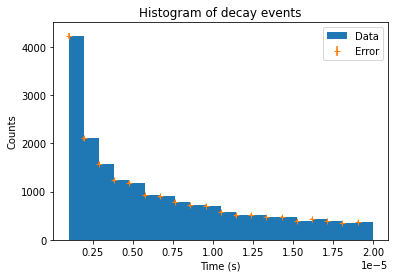

In [ ]:
x_axis = 0
filt_data = []

for val in data:
  if val > 0 and val <= 2e-5:
    filt_data.append(val)
  else:
    pass

filt_data = np.array(filt_data)
ln_filt = np.log(filt_data)

n, bins, patches = plt.hist(filt_data, bins=20, label="Data")
y_axis, x_axis = np.histogram(filt_data, bins=20)
x_axis = x_axis[:-1]
err = np.sqrt(y_axis)
#plt.scatter(x_axis, y_axis)
plt.errorbar(x_axis, y_axis, yerr=err, fmt="+", label="Error")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Counts")
plt.title("Histogram of decay events")
#plt.xticks(mid, labels=mid)
#plt.xlim(0, 0.05)
#plt.ylim(0, 1000)

Text(0, 0.5, 'ln(counts)')

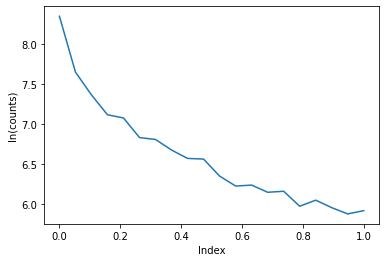

In [ ]:
x_axis = np.linspace(0, 1, len(n))
plt.plot(x_axis, np.log(n))
plt.xlabel("Index")
plt.ylabel("ln(counts)")

In [ ]:
print(n)
print(bins[1]-bins[0])

[4235. 2107. 1583. 1234. 1186.  928.  906.  794.  715.  709.  573.  506.
  512.  468.  474.  393.  424.  386.  357.  372.]
9.5e-07


In [ ]:
times = []
for index in range(0, len(n)):
  times.append((bins[index+1]+bins[index])/2)
mid = np.array(times)
print(mid, len(mid))
#print(mid[1]-mid[0], mid[2]-mid[1])

[1.4750e-06 2.4250e-06 3.3750e-06 4.3250e-06 5.2750e-06 6.2250e-06
 7.1750e-06 8.1250e-06 9.0750e-06 1.0025e-05 1.0975e-05 1.1925e-05
 1.2875e-05 1.3825e-05 1.4775e-05 1.5725e-05 1.6675e-05 1.7625e-05
 1.8575e-05 1.9525e-05] 20


In [ ]:
def exp(time, N, l):
  return N*np.exp(-l*time)

In [ ]:
def binlnL(time, n, taus, width, Nopt):
  array = []
  sum = 0
  for val in taus:
    for index in range(0, len(time)):
      sum += (n[index]*np.log(exp(time[index], Nopt, 1/val)*width)) - (exp(time[index], Nopt, 1/val)*width)
    array.append(sum)
  return array

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
popt, pcov = curve_fit(exp, mid, n, p0=[16000, 1/2.5e-6])
print(popt)

[  4661.56229932 233115.88694478]


In [ ]:
print(1/popt[1])
print(1/2.2e-6)

4.289711924425292e-06
454545.45454545453


Text(0.5, 1.0, 'curve_fit() optimized fit for muon decay time')

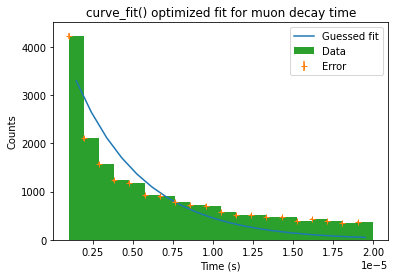

In [ ]:
plt.plot(mid, exp(mid, *popt), label="Guessed fit")
plt.errorbar(x_axis, y_axis, yerr=err, fmt="+", label="Error")
n, bins, patches = plt.hist(filt_data, bins=20, label="Data")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Counts")
plt.title("curve_fit() optimized fit for muon decay time")

In [49]:
print(bins[1]-bins[0])

9.5e-07


In [50]:
lerr = np.sqrt(np.diag(pcov)) # Finding the error of the fit from the covariance matrix
print(lerr)

[  584.27716754 32838.17528891]


If error in 1/t = 15997.0008, then error in t is

d(1/t) = |-1/t^2| * dt

In [51]:
tauerr = lerr[1]*((1/popt[1])**2)
print(tauerr)

6.042758988217866e-07


Therefore the error is about 0.374 us!

New fitting using binned ml

In [52]:
from scipy.special import gammaln
from scipy.signal import find_peaks

In [53]:
def lnprob(t_i, count, tau, N0):
  mean = N0*(np.exp(-t_i/tau))
  ln_p_i = count*np.log(mean) - gammaln(count) - mean
  return ln_p_i

Text(0, 0.5, 'Sum of ln(P{i, tau})')

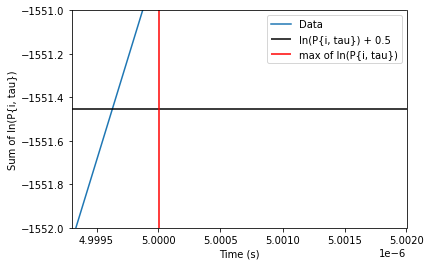

In [129]:
counts = []
for val in n:
  counts.append(int(val))

counts = np.array(counts)
times = mid
taus = np.linspace(1e-6, 100e-6, 100)
#print(type(taus[0]))
probs = []
for val in taus:
  totp = 0
  for index in range(0, len(counts)):
    totp += lnprob(times[index], counts[index], val, N0=popt[0])
  probs.append(totp)

plt.xlim(4.9993e-6, 5.002e-6)
plt.ylim(-1552, -1551)
plt.plot(taus, probs, label="Data")
plt.hlines(max(probs)+np.log(0.5), 0, 0.00004, color="black", label="ln(P{i, tau}) + 0.5")
plt.xlabel("Time (s)")
plt.vlines(5e-06, 0, -2000, color="red", label="max of ln(P{i, tau})")
plt.legend()
plt.ylabel("Sum of ln(P{i, tau})")
#plt.vlines(probs[4])
#plt.vlines(5.5e-6, -80000, 0, color="black")

In [ ]:
for 

In [ ]:
find_peaks(probs)
print(probs[4])
print(taus[4])

-1550.762472998575
5e-06


In [ ]:
def totln(opts, times, counts):
    N0, tau = opts[0], opts[1]
    totp = 0
    for index in range(0, len(counts)):
      totp += lnprob(times[index], counts[index], tau, N0=popt[0])
    return(-1*totp)

In [ ]:
minimize(totln, x0=[4000, 5.5e-6], method="Nelder-Mead", args=(times, counts))

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1396.639876407346
             x: [ 4.738e+03  5.465e-06]
           nit: 70
          nfev: 177
 final_simplex: (array([[ 4.738e+03,  5.465e-06],
                       [ 4.738e+03,  5.465e-06],
                       [ 4.738e+03,  5.465e-06]]), array([ 1.397e+03,  1.397e+03,  1.397e+03]))